# Music recommender system
## _Collaborative filters

### Importing required libraries

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [72]:
from scipy.sparse import csr_matrix

In [73]:
from surprise import SVD
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

## Reading the files

In [74]:
song_info = pd.read_csv('10000.txt',sep='\t',header=None)
song_info.columns = ['user_id', 'song_id', 'listen_count']

#Read song  metadata
song_actual =  pd.read_csv('song_data.csv')
song_actual.drop_duplicates(['song_id'], inplace=True)

#Merge the two dataframes above to create input dataframe for recommender systems
df_songs= pd.merge(song_info, song_actual, on="song_id", how="left")


## Exploring the data

In [75]:
df_songs.head()

,user_id,song_id,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


In [76]:
df_songs.shape

(2000000, 7)

## we can see that there is no missing values

In [77]:
df_songs.isnull().sum()

user_id         0
song_id         0
listen_count    0
title           0
release         0
artist_name     0
year            0
dtype: int64

## And most of the columns contain strings

In [78]:
df_songs.dtypes

user_id         object
song_id         object
listen_count     int64
title           object
release         object
artist_name     object
year             int64
dtype: object

## Let's start exploring some characteristics of the dataset:

## .Unique songs:

In [79]:
unique_songs = df_songs.title.unique().shape[0]
print(f"There are {unique_songs} unique songs in the dataset")

There are 9567 unique songs in the dataset


## .Unique artist

In [80]:
unique_artist = df_songs.artist_name.unique().shape[0]
print(f"There are {unique_artist} unique artist in the dataset")

There are 3375 unique artist in the dataset


## .Unique users

In [81]:
unique_users = df_songs.user_id.unique().shape[0]
print(f"There are {unique_users} unique users in the dataset")

There are 76353 unique users in the dataset


# Most popular songs

In [82]:
#count how many rows we have by song, we show only the ten more popular songs

ten_pop_songs = df_songs.groupby('title')['listen_count'].count().reset_index().sort_values('listen_count' , ascending=False)


In [83]:
ten_pop_songs = ten_pop_songs[:10]
ten_pop_songs

,title,listen_count
6836,Sehr kosmisch,8277
8725,Undo,7032
1964,Dog Days Are Over (Radio Edit),6949
9496,You're The One,6729
6498,Revelry,6145
6825,Secrets,5841
3437,Horn Concerto No. 4 in E flat K495: II. Romanc...,5385
2595,Fireflies,4795
3322,Hey_ Soul Sister,4758
8494,Tive Sim,4548


In [97]:
labels = ten_pop_songs['title']
counts = ten_pop_songs['listen_count']

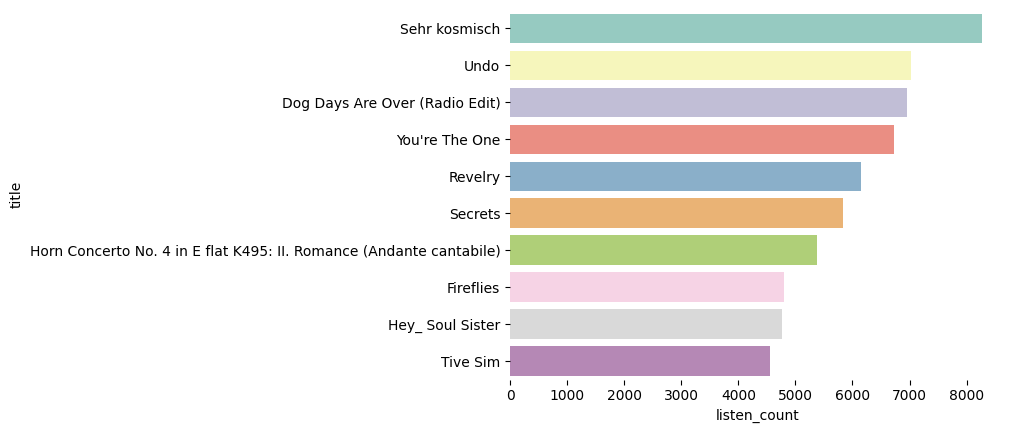

In [98]:

sns.barplot(x=counts  , y=labels , palette='Set3')
#to remove different borders 
sns.despine(left=True, bottom=True)

# Most popular artist

In [89]:
#count how many rows we have by artist name, we show only the ten more popular artist 

ten_pop_artists = df_songs.groupby('artist_name')['listen_count'].count().reset_index().sort_values('listen_count' , ascending=False)


In [90]:
ten_pop_artists = ten_pop_artists[:10]
ten_pop_artists

,artist_name,listen_count
649,Coldplay,29422
2850,The Black Keys,19862
1651,Kings Of Leon,18747
1107,Florence + The Machine,18112
1370,Jack Johnson,17801
2946,The Killers,16063
2374,Radiohead,14890
736,Daft Punk,14715
2073,Muse,14005
1554,Justin Bieber,13959


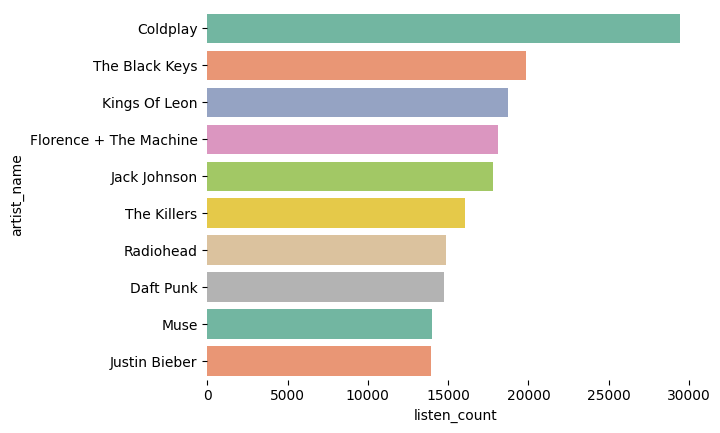

In [96]:
labels = ten_pop_artists['artist_name']
counts = ten_pop_artists['listen_count']
sns.barplot(x=counts, y=labels, palette='Set2')
sns.despine(left=True, bottom=True)

## How many times on average the same user listen to a same song?

In [92]:
print(f"On average, a user listen to the same song {df_songs['listen_count'].mean()} times")

On average, a user listen to the same song 3.0454845 times


## How many songs does a user listen in average?

In [100]:
song_user = df_songs.groupby('user_id')['song_id'].count()

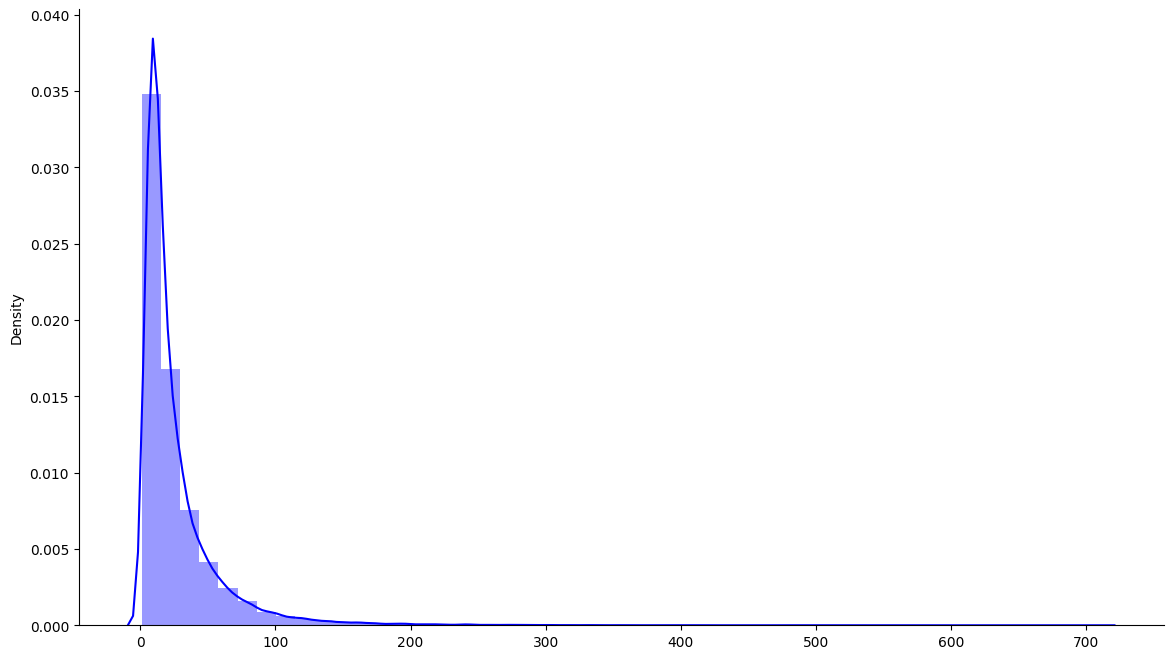

In [106]:
plt.figure(figsize=(14, 8))
sns.distplot(song_user.values, color='blue')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();


In [110]:
print(f"A user listens to an average of {np.mean(song_user)} songs")

A user listens to an average of 26.194124657839247 songs


# Prepare the data

## Filtered the dataset to keep only those users with more than 16 listened

In [111]:
# Get how many songs each user have listened to
user_counts = df_songs.groupby('user_id')['song_id'].count()

# Filter users which have listen to at least 16 songs
user_ten_id = user_counts[user_counts > 16].index.to_list()

In [112]:
song_counts = df_songs.groupby('song_id')['user_id'].count()

# Get songs which have been listened at least 4 times
song_ten_id = song_counts[song_counts > 200].index.to_list()


In [113]:
df_song_reduced = df_songs[(df_songs['user_id'].isin(user_ten_id)) & (df_songs['song_id'].isin(song_ten_id))].reset_index(drop=True)


In [114]:
df_song_reduced.shape

(950353, 7)

# Model and recommendations

In [115]:
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 2214]

In [116]:
df_song_reduced['listen_count'] = pd.cut(df_song_reduced['listen_count'], bins=bins, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [117]:
listen_counts = pd.DataFrame(df_song_reduced.groupby('listen_count').size(), columns=['count']).reset_index(drop=False)

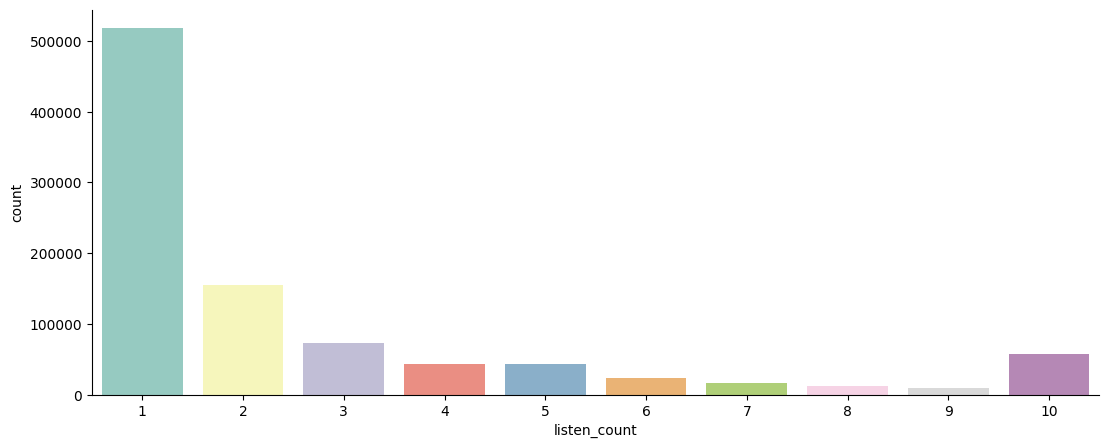

In [120]:
plt.figure(figsize=(13, 5))
sns.barplot(x='listen_count', y='count', palette='Set3', data=listen_counts)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

## For this topic, we are going to use a fun package called surprise. Surprise is an easy-to-use Python library specially designed for recommender systems.

## We will need to pass the following parameters:

##    1.df: The dataframe containing the ratings. It must have three columns, corresponding to the user ids, the song ids, and the ratings.
##    2.reader (Reader): A reader to read the file. Only the rating_scale field needs to be specified.



In [121]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(df_song_reduced[['user_id', 'song_id', 'listen_count']], reader)

In [122]:
trainset, testset = train_test_split(data, test_size=.25)


## GridSearchCV

In [123]:
param_grid = {'n_factors': [160], 
              'n_epochs': [100], 
              'lr_all': [0.001, 0.005],
              'reg_all': [0.08, 0.1]}

In [124]:
grid_search_svd = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, joblib_verbose=4, n_jobs=-2)

In [126]:
# find the best parameters for the model
grid_search_svd.fit(data)
find_algo = grid_search_svd.best_estimator['rmse']
print(grid_search_svd.best_score['rmse'])
print(grid_search_svd.best_params['rmse'])



[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 out of  12 | elapsed:   46.7s remaining:  2.3min
[Parallel(n_jobs=-2)]: Done   7 out of  12 | elapsed:   53.2s remaining:   38.0s


2.200099222426757
{'n_factors': 160, 'n_epochs': 100, 'lr_all': 0.005, 'reg_all': 0.1}


[Parallel(n_jobs=-2)]: Done  12 out of  12 | elapsed:  1.4min finished


In [127]:
# Perform the cross validation
cross_validate(find_algo, data, measures=['RMSE'], cv=5, verbose=True)


Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.1750  2.1742  2.1720  2.1713  2.1747  2.1735  0.0015  
Fit time          34.55   34.00   34.23   34.35   34.25   34.28   0.18    
Test time         0.61    0.61    0.62    0.62    0.63    0.62    0.01    


{'test_rmse': array([2.17495124, 2.17422392, 2.17202354, 2.1713492 , 2.17474768]),
 'fit_time': (34.553207874298096,
  33.99794363975525,
  34.22824263572693,
  34.353530406951904,
  34.24585485458374),
 'test_time': (0.6101579666137695,
  0.6109719276428223,
  0.6195924282073975,
  0.6185297966003418,
  0.6319866180419922)}

In [128]:
final_algorithm = SVD(n_factors=160, n_epochs=100, lr_all=0.005, reg_all=0.1)
final_algorithm.fit(trainset)
test_predictions = final_algorithm.test(testset)
print(f"The RMSE is {accuracy.rmse(test_predictions, verbose=True)}")


RMSE: 2.1842
The RMSE is 2.1842130095383863
